# Construction PPE Object Detection: 
### <b><u>Hybrid Model Training</b></u>
##### AAI-501 Group 4: Fatimat Atanda, Victor Hugo Germano, Darin Verduzco
GitHub: https://github.com/victorhg/aai-501-final-project

# Dataset setup:
Download hybrid "datasets" folder
<br>into the current <b><u>"hybrid_model_train"</b></u> directory:
<br><br><b>Manually-annotated datasets: For images annotated manually</b>
<br>./datasets/manually_annotated/raw_images (178 images)
<br>./datasets/manually_annotated/raw_labels (178 labels)
<b><br><br>Auto-annotated datasets: For images annotated with pre-trained model</b>
<br>- Raw Images Datasets: Contains images not annotated
<br>./datasets/raw_images (2746 images)
<br>(note: file names larger than 99 characters may not be read, update manually)

<br> 12/23/24 update: hybrid bias check dataset (2,924 total images):
<br> 178 images manually annotated (6.09% of total)
<br> 58 holdout test set of custom images manually annotated (1.98% of total) 
<br> 2688 images for auto annotation (91.93% of total)

### Import Modules and Libraries

In [1]:
import os # File 
import cv2 # Opencv for images
import yaml
import glob
import torch
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ultralytics import YOLO # For obeject detection
import albumentations as A # For image augmentation
from albumentations.pytorch import ToTensorV2 # For image formating
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\DARiN\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Define directories

In [2]:
# Create direcories to organize images and cleanup for to avoid duplicate images 
dataset_base_dir = "datasets/"
# Source directory containing all raw manually annotated images
manual_source_images_dir = os.path.join(dataset_base_dir, "manually_annotated/raw_images")
manual_source_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/raw_labels")
# Source directory containing all raw unannotated images 
raw_images_dir = os.path.join(dataset_base_dir, "raw_images")

# Create auto-annotated directories
auto_annotated_images_dir = os.path.join(dataset_base_dir, "auto_annotated/images")
auto_annotated_labels_dir = os.path.join(dataset_base_dir, "auto_annotated/labels")
# Create manually annotated directories
manual_train_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/train")
manual_train_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/train")
manual_val_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/val")
manual_val_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/val")

### Reset directories

In [23]:
def reset_directories(directories):
    """
    Check if directories exist. Delete and recreate them if they do.
    Ensures the directories are clean before use.

    Parameters:
        directories (list): List of directories to reset.
    """
    for path in directories:
        if os.path.exists(path):
            # delete the directory and all its contents
            try:
                shutil.rmtree(path)
                print(f"Deleted existing directory: {path}")
            except Exception as e:
                print(f"Failed to delete {path}. Reason: {e}")
        
        # Recreate the directory
        try:
            os.makedirs(path, exist_ok=True)
            print(f"Recreated directory: {path}")
        except Exception as e:
            print(f"Failed to create directory {path}. Reason: {e}")

# Define directories to reset
directories_to_reset = [
    auto_annotated_images_dir,
    auto_annotated_labels_dir,


    # manually annotated directories
    manual_train_images_dir,
    manual_train_labels_dir,
    manual_val_images_dir,
    manual_val_labels_dir 
]

# Reset directories
reset_directories(directories_to_reset)
print("Directories reset and ready for use.")

# Set random seed for reproducibility
random.seed(42)

Deleted existing directory: datasets/auto_annotated/images
Recreated directory: datasets/auto_annotated/images
Deleted existing directory: datasets/auto_annotated/labels
Recreated directory: datasets/auto_annotated/labels
Deleted existing directory: datasets/manually_annotated/images/train
Recreated directory: datasets/manually_annotated/images/train
Deleted existing directory: datasets/manually_annotated/labels/train
Recreated directory: datasets/manually_annotated/labels/train
Deleted existing directory: datasets/manually_annotated/images/val
Recreated directory: datasets/manually_annotated/images/val
Deleted existing directory: datasets/manually_annotated/labels/val
Recreated directory: datasets/manually_annotated/labels/val
Directories reset and ready for use.


### Create manual_data.yaml

In [3]:
# create manual_data.yaml in local datasets folder
ppe_classes = [
    'Hardhat',
    'Mask',
    'NO-Hardhat',
    'NO-Mask',
    'NO-Safety Vest',
    'Person',
    'Safety Cone',
    'Safety Vest',
    'Machinery',
    'Vehicle'
]
number_classes = len(ppe_classes)
output_dir = 'datasets'

dict_file = {
    'train': 'manually_annotated/images/train',
    'val': 'manually_annotated/images/val',
    'nc': number_classes,
    'names': ppe_classes
}

with open(os.path.join(dataset_base_dir, 'manual_data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)
# Full yaml path to prevent path error
manual_yaml_path = str(Path('datasets/manual_data.yaml').resolve())

### Create final_hybrid_data.yaml

In [25]:
# create final yaml in datasets 
dict_file = {
    'train': 'images/train', 
    'val': 'images/val',
    'test': 'images/test', 
    'nc': number_classes,
    'names': ppe_classes
}

with open(os.path.join(dataset_base_dir, 'final_hybrid_data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)
# Full yaml path to prevent path error
final_yaml_path = str(Path('datasets/final_hybrid_data.yaml').resolve())

### Random Image Visualization

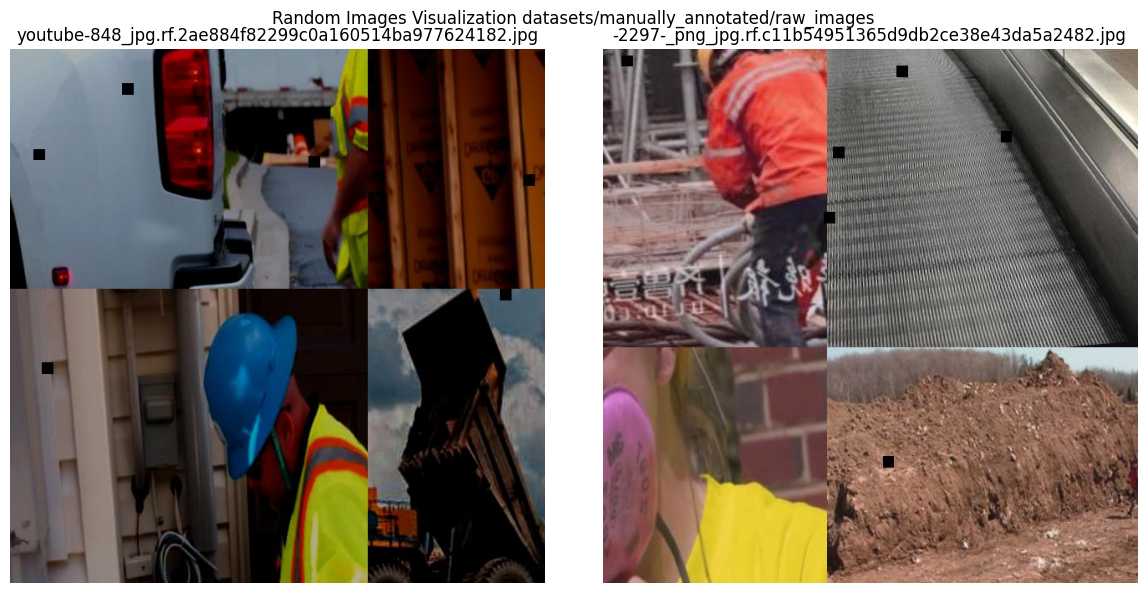

In [26]:
# define function to visualize random images
def visualize_images(images_dir, num_images=5):
    random.seed(42)
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(selected_files):
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(image_file)
    plt.suptitle(f"Random Images Visualization {images_dir}")
    plt.tight_layout()
    plt.show()
    
visualize_images(manual_source_images_dir, num_images=2)

### Custom images dataset

In [27]:
# Get the paths to the first three custom images
image_paths = glob.glob(f"{manual_source_images_dir}/scene*.jpg")[:3]

# Check if there are enough images
if len(image_paths) < 3:
    print("Not enough images found!")
else:
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(13, 7))  # Width, height

    for i, ax in enumerate(axes):
        # Load and display each image
        image = mpimg.imread(image_paths[i])
        ax.imshow(image)
        ax.axis('off')  # Hide axes
        ax.set_title(f"Custom Manual Annotation Train Image {i}")

    plt.tight_layout()
    plt.show()

Not enough images found!


### Google images dataset

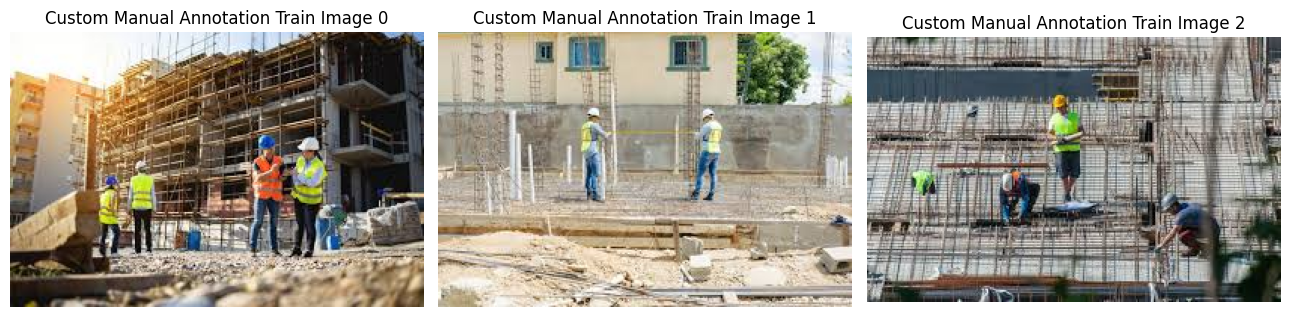

In [28]:
# Get the paths to the first three custom images
image_paths = glob.glob(f"{raw_images_dir}/images*.jpeg")[:3]

# Check if there are enough images
if len(image_paths) < 3:
    print("Not enough images found!")
else:
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(13, 7))  # Width, height

    for i, ax in enumerate(axes):
        # Load and display each image
        image = mpimg.imread(image_paths[i])
        ax.imshow(image)
        ax.axis('off')  # Hide axes
        ax.set_title(f"Custom Manual Annotation Train Image {i}")

    plt.tight_layout()
    plt.show()

### Image Properties

In [29]:
# Define function to analyze image dimensions, aspect ratio
def analyze_image_properties(images_dir):
    properties = {"filename": [], "width": [], "height": [], "aspect_ratio": []}

    for image_file in os.listdir(images_dir):
        if image_file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(images_dir, image_file)
            image = cv2.imread(image_path)
            height, width = image.shape[:2]
            aspect_ratio = width / height
            properties["filename"].append(image_file)
            properties["width"].append(width)
            properties["height"].append(height)
            properties["aspect_ratio"].append(aspect_ratio)

    # Convert to pandas DataFrame for analysis
    df = pd.DataFrame(properties)
    return df
print("Image Properties Analysis Of Manually Labeled Images")
analyze_image_properties(manual_source_images_dir)

Image Properties Analysis Of Manually Labeled Images


filename  width  height  \
0    -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...    640     640   
1    -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...    640     640   
2    -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...    640     640   
3    -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...    640     640   
4    -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...    640     640   
..                                                 ...    ...     ...   
173  youtube-855_jpg.rf.016160b803b33611610bba867eb...    640     640   
174  youtube-855_jpg.rf.346f539ebe7317c5c7202185ddd...    640     640   
175  youtube-855_jpg.rf.8423bd3eccf6197cf223448ef5d...    640     640   
176  youtube-855_jpg.rf.c1f7df1e079c07197ea93a64a0a...    640     640   
177  youtube-855_jpg.rf.ca4e205a81e38caeee1ae4bfce7...    640     640   

     aspect_ratio  
0             1.0  
1             1.0  
2             1.0  
3             1.0  
4             1.0  
..            ...  
173           1.0  
174           1.0  
175           1.0  
176           1.0  
177           1.0  

[178 rows x 4 columns]

### Split manually annotated datasets to train and val

In [30]:
# Define function to split manually annotated dataset into train and valation sets
def split_manual_dataset(images_dir, labels_dir, split_ratio=0.8):
    image_files = [
        f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    random.shuffle(image_files)

    train_size = int(split_ratio * len(image_files))
    train_files = image_files[:train_size]
    val_files = image_files[train_size:]

    # Copy train files and corresponding labels
    for file in train_files:
        label_file = os.path.splitext(file)[0] + ".txt"  # Match label with image file
        image_src = os.path.join(images_dir, file)
        label_src = os.path.join(labels_dir, label_file)
        shutil.copy(image_src, os.path.join(manual_train_images_dir, file))
        shutil.copy(label_src, os.path.join(manual_train_labels_dir, label_file))

    # Copy val files and corresponding labels
    for file in val_files:
        label_file = os.path.splitext(file)[0] + ".txt"  # Match label with image file
        image_src = os.path.join(images_dir, file)
        label_src = os.path.join(labels_dir, label_file)
        shutil.copy(image_src, os.path.join(manual_val_images_dir, file))
        shutil.copy(label_src, os.path.join(manual_val_labels_dir, label_file))

    print("Manual dataset split completed. Images and labels copied to train and val directories.")

split_manual_dataset(manual_source_images_dir, manual_source_labels_dir)

Manual dataset split completed. Images and labels copied to train and val directories.


### <b><u>Train base model</b></u> with manually annotated datasets

In [12]:
proj_name1 = input('Please enter base model run folder description: ')
# Train the generic model on manually labeled data
def train_model(manual_train_images, manual_val_images, epochs=50):

    # Train the model
    print("Training model on manually labeled dataset...")
    model = YOLO("../../models/yolov8m.pt")
    model.train(
        data=manual_yaml_path,
        epochs=50, # Iterations
        imgsz=640, # Image size
        batch=16, # Batch size
        seed=88, # Train Repeatability
        lr0=1e-4,  # Learning rate 
        optimizer="auto", # Automatic speed, stability optimization
        patience=10, # Num of epochs to discontinue unimproved train
        name = proj_name1 # input for run description
    )
    print("Model training completed.")
    return model

# Train the model on the manual dataset
trained_model = train_model(manual_train_images_dir, manual_val_images_dir)

Please enter base model run folder description:  hybrid base - no manual data


Training model on manually labeled dataset...
Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
engine\trainer: task=detect, mode=train, model=../../models/yolov8m.pt, data=C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\manual_data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=hybrid base - no manual data, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fals

train: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\m

train: New cache created: C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\manually_annotated\labels\train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\man

val: New cache created: C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\manually_annotated\labels\val.cache
Plotting labels to runs\detect\hybrid base - no manual data\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\hybrid base - no manual data
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.665        3.5      1.751        221        640: 100%|██████████| 9/9 [01:12<00:00,  8.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<0

                   all         36        471      0.446      0.188      0.168     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.416      2.295      1.555        267        640: 100%|██████████| 9/9 [01:08<00:00,  7.56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<0

                   all         36        471      0.309      0.391      0.308      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.261      1.925      1.427        258        640: 100%|██████████| 9/9 [01:06<00:00,  7.41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<0

                   all         36        471      0.421      0.343      0.347      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.256      1.764       1.41        328        640: 100%|██████████| 9/9 [01:07<00:00,  7.51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.399       0.42      0.372      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.212      1.666      1.356        234        640: 100%|██████████| 9/9 [01:13<00:00,  8.18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.448      0.417       0.39      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.226      1.613      1.379        322        640: 100%|██████████| 9/9 [01:08<00:00,  7.61
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471       0.43      0.416      0.383      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G        1.2       1.48      1.357        246        640: 100%|██████████| 9/9 [01:08<00:00,  7.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.632      0.379      0.444       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.203      1.356      1.346        282        640: 100%|██████████| 9/9 [01:10<00:00,  7.84
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.533      0.379      0.382      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.125      1.332      1.321        266        640: 100%|██████████| 9/9 [01:10<00:00,  7.83
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.409      0.387      0.355      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.186      1.334       1.37        405        640: 100%|██████████| 9/9 [01:13<00:00,  8.14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.519      0.365      0.379      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.138      1.285      1.341        225        640: 100%|██████████| 9/9 [01:09<00:00,  7.76
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471       0.51      0.377      0.383      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.144       1.29      1.339        231        640: 100%|██████████| 9/9 [01:08<00:00,  7.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.491      0.393      0.405      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.145      1.218       1.31        276        640: 100%|██████████| 9/9 [01:06<00:00,  7.39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.649      0.357      0.434      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.114       1.17      1.298        244        640: 100%|██████████| 9/9 [01:09<00:00,  7.68
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.652      0.446      0.465      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.063      1.107      1.257        285        640: 100%|██████████| 9/9 [01:04<00:00,  7.20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.712      0.416      0.467      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.043      1.071      1.238        273        640: 100%|██████████| 9/9 [01:10<00:00,  7.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.611      0.477      0.476      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.074      1.085      1.269        252        640: 100%|██████████| 9/9 [01:03<00:00,  7.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.635      0.446      0.472      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.056      1.065       1.25        374        640: 100%|██████████| 9/9 [01:03<00:00,  7.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.662      0.501      0.523      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.9925      1.016      1.225        257        640: 100%|██████████| 9/9 [01:03<00:00,  7.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.753      0.451      0.526      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.001     0.9858      1.239        329        640: 100%|██████████| 9/9 [01:05<00:00,  7.31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.714      0.558      0.596      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.9898     0.9673      1.208        263        640: 100%|██████████| 9/9 [01:04<00:00,  7.16
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.771      0.508      0.586      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.9621     0.9468      1.208        294        640: 100%|██████████| 9/9 [01:03<00:00,  7.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.653      0.536      0.572      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9471     0.9267      1.191        463        640: 100%|██████████| 9/9 [01:03<00:00,  7.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.743      0.542      0.588      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.9474     0.8926      1.187        290        640: 100%|██████████| 9/9 [01:03<00:00,  7.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.773      0.514       0.59      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.9332      0.891       1.17        277        640: 100%|██████████| 9/9 [01:04<00:00,  7.15
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.769      0.531      0.598      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.9105      0.869      1.163        301        640: 100%|██████████| 9/9 [01:03<00:00,  7.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.775      0.511      0.601      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.8837     0.8248      1.152        293        640: 100%|██████████| 9/9 [01:04<00:00,  7.19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.779      0.516      0.601      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.8771      0.796       1.15        209        640: 100%|██████████| 9/9 [01:04<00:00,  7.18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.726      0.555      0.613      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.8597      0.746       1.11        314        640: 100%|██████████| 9/9 [01:47<00:00, 11.98
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         36        471      0.756      0.554      0.638      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.8378     0.7522      1.139        236        640: 100%|██████████| 9/9 [01:04<00:00,  7.19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.812      0.575      0.657      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.8273     0.7652      1.126        209        640: 100%|██████████| 9/9 [01:08<00:00,  7.63
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.797      0.578      0.643      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.8095     0.7115       1.11        241        640: 100%|██████████| 9/9 [01:17<00:00,  8.61
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471       0.76      0.583      0.646      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      0.828     0.7429      1.113        273        640: 100%|██████████| 9/9 [01:14<00:00,  8.25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.777      0.583      0.645       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      0.823     0.7292      1.118        218        640: 100%|██████████| 9/9 [01:15<00:00,  8.38
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471       0.77      0.579      0.647      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.7919     0.6768      1.087        328        640: 100%|██████████| 9/9 [01:16<00:00,  8.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.704      0.623       0.65      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.7663     0.6836       1.07        313        640: 100%|██████████| 9/9 [01:16<00:00,  8.48
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.795      0.595      0.666      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.7699     0.6691      1.073        392        640: 100%|██████████| 9/9 [01:15<00:00,  8.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.784      0.607      0.658      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.7441     0.6553      1.056        306        640: 100%|██████████| 9/9 [01:16<00:00,  8.48
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471       0.78       0.59      0.647       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.7185     0.6246      1.054        264        640: 100%|██████████| 9/9 [01:16<00:00,  8.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.837      0.563      0.647      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.7341     0.6246      1.059        324        640: 100%|██████████| 9/9 [01:16<00:00,  8.49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.838      0.585      0.673      0.425


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.7676     0.6492      1.063        150        640: 100%|██████████| 9/9 [01:15<00:00,  8.38
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.815      0.613      0.674      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.7119      0.561      1.037        151        640: 100%|██████████| 9/9 [01:15<00:00,  8.37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471        0.8      0.611      0.676      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.6764     0.5368      1.014        156        640: 100%|██████████| 9/9 [01:15<00:00,  8.40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.773      0.619       0.67      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.6626     0.5065      1.027        181        640: 100%|██████████| 9/9 [01:14<00:00,  8.29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.773      0.628      0.677      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.6608     0.5089      1.023        158        640: 100%|██████████| 9/9 [01:12<00:00,  8.06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.793       0.62      0.679      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.6657     0.5181      1.025        141        640: 100%|██████████| 9/9 [01:12<00:00,  8.07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.815      0.601      0.682       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.6445     0.4843     0.9931        219        640: 100%|██████████| 9/9 [01:12<00:00,  8.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.794      0.613      0.684      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.6202     0.4757     0.9957        137        640: 100%|██████████| 9/9 [01:13<00:00,  8.21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.775      0.625      0.687      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.6222     0.4696     0.9928        272        640: 100%|██████████| 9/9 [01:14<00:00,  8.24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.784      0.624      0.689      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.6029     0.4782     0.9835        197        640: 100%|██████████| 9/9 [01:13<00:00,  8.18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<0

                   all         36        471      0.804      0.609       0.69      0.441



50 epochs completed in 1.095 hours.
Optimizer stripped from runs\detect\hybrid base - no manual data\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\hybrid base - no manual data\weights\best.pt, 52.0MB

Validating runs\detect\hybrid base - no manual data\weights\best.pt...
Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0


                   all         36        471      0.803      0.609       0.69      0.441
               Hardhat         21         41      0.891       0.61      0.698      0.482
                  Mask         15         21      0.877      0.762      0.897      0.628
            NO-Hardhat         12         21      0.729      0.667      0.699      0.435
               NO-Mask         25         51       0.76      0.497      0.551      0.278
        NO-Safety Vest         19         45      0.769      0.644      0.692      0.437
                Person         34        106      0.891      0.691      0.789      0.523
           Safety Cone         14         79       0.82      0.404      0.513      0.279
           Safety Vest         16         25      0.805       0.64      0.735      0.443
             Machinery         25         61      0.713      0.557      0.646      0.405
               Vehicle         12         21      0.774      0.619      0.675        0.5
Speed: 0.9ms preproce

### Automatically annotate datasets with base model

In [31]:
# load the pre-trained model to auto annotated the raw_images
model_path = "runs/detect/hybrid base - no manual data/weights/best.pt"  # Path to your trained YOLO model
def auto_annotate_images(model_path, raw_images_dir, output_images_dir, output_labels_dir, confidence_threshold=0.5):
    
    """
    Automatically annotate images using a pre-trained YOLO model.

    Args:
    - model_path (str): Path to the trained YOLO model.
    - raw_images_dir (str): Path to the directory containing raw images.
    - output_images_dir (str): Path to save annotated images.
    - output_labels_dir (str): Path to save annotation labels in YOLO format.
    - confidence_threshold (float): Minimum confidence score to include a detection.
    """
    total_images = len([image_file for image_file in os.listdir(raw_images_dir) if image_file.lower().endswith(('.jpg', '.jpeg', '.png'))])
    # load the pre-trained model
    model = YOLO(model_path)

    # Create output directories if they don't exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)
        
    for i, image_file in enumerate(os.listdir(raw_images_dir)):
        if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(raw_images_dir, image_file)
            results = model(image_path, verbose=False)  # Perform inference, silence output for each image

            # Save the original image to the output directory
            output_image_path = os.path.join(output_images_dir, image_file)
            cv2.imwrite(output_image_path, cv2.imread(image_path))

            # Prepare the YOLO format label file
            label_file = os.path.splitext(image_file)[0] + ".txt"
            output_label_path = os.path.join(output_labels_dir, label_file)

            with open(output_label_path, "w") as f:
                for result in results[0].boxes:
                    box = result.xywhn[0].cpu().numpy()  # Normalized x_center, y_center, width, height
                    class_id = int(result.cls[0].cpu().numpy())
                    confidence = float(result.conf[0].cpu().numpy())

                    # Filter by confidence threshold
                    if confidence >= confidence_threshold:
                        f.write(f"{class_id} {box[0]:.3f} {box[1]:.3f} {box[2]:.3f} {box[3]:.3f}\n")

            # Print the current progress (overwrite previous line)
            print(f"Annotating image {i+1} of {total_images}...", end='\r')
    
    print(f"Auto-annotation completed.\n' Annotated images and labels saved in {output_images_dir} and {output_labels_dir}.")
        
auto_annotate_images(model_path, raw_images_dir, auto_annotated_images_dir, auto_annotated_labels_dir)

Auto-annotation completed.688...
' Annotated images and labels saved in datasets/auto_annotated/images and datasets/auto_annotated/labels.


### Visualize auto-annotated datasets for model accuracy

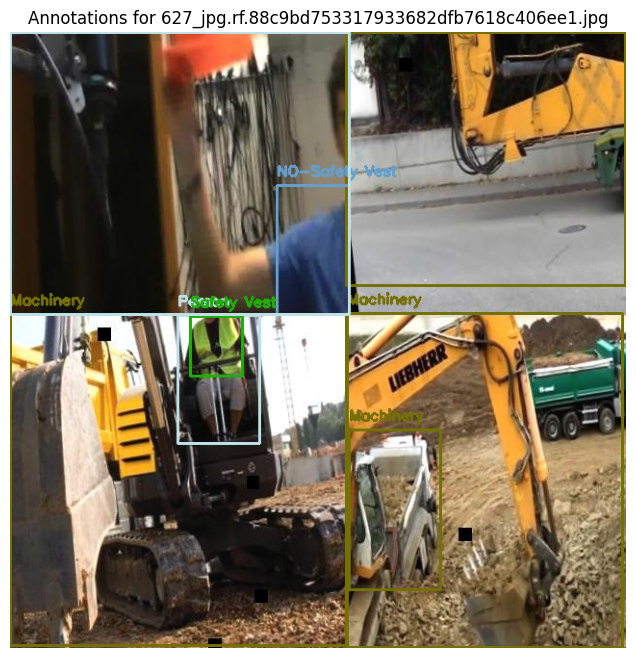

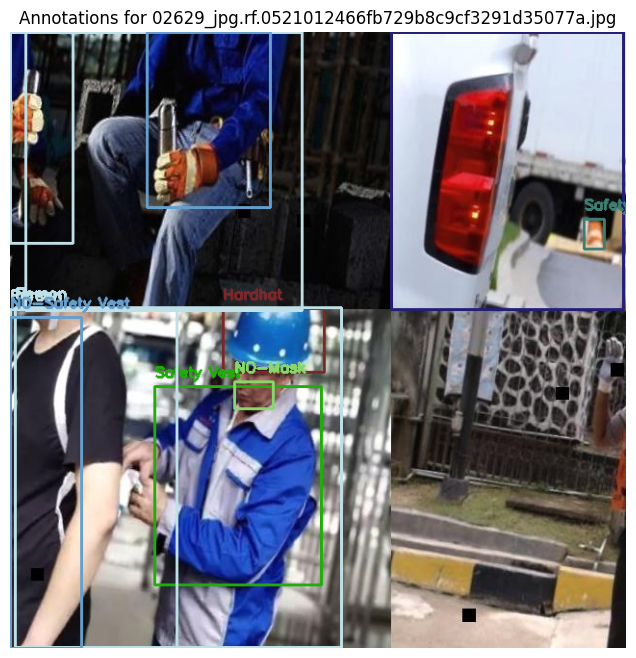

In [32]:
# visualize auto-annotation to ensure correct bounding
def visualize_annotations(image_dir, label_dir, ppe_classes, num_images=5):
    """
    Visualize YOLO-format annotations on images.

    Args:
    - image_dir (str): Path to the directory containing annotated images.
    - label_dir (str): Path to the directory containing YOLO-format label files.
    - ppe_classes (list): List of class names corresponding to class IDs.
    - num_images (int): Number of images to visualize.
    """

    num_classes = len(ppe_classes)
    colors = [
        (random.randint(0, 255),
         random.randint(0, 255),
         random.randint(0, 255)) for _ in range(num_classes)
    ]

    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Select a subset of images to visualize
    image_files = random.sample(image_files, min(num_images, len(image_files)))

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image: {image_file}")
            continue

        # Convert the image to RGB for visualization
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_file)
        if not os.path.exists(label_path):
            print(f"Label file not found for image: {image_file}")
            continue

        with open(label_path, "r") as f:
            labels = f.readlines()

        # Overlay bounding boxes and class names on the image
        for label in labels:
            label_data = label.strip().split()
            class_id = int(label_data[0])
            x_center, y_center, width, height = map(float, label_data[1:])

            # Convert normalized YOLO coordinates to image pixel coordinates
            img_height, img_width, _ = image.shape
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            # Draw the bounding box
            #color = (255, 0, 0)  # Blue color for bounding box
            color = colors[class_id]
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put the class name text
            label_text = f"{ppe_classes[class_id]}"
            cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Annotations for {image_file}")
        plt.show()

visualize_annotations(auto_annotated_images_dir, auto_annotated_labels_dir, ppe_classes, num_images=2)

### Combine manual and auto annotated datasets

In [33]:
# Function to combine datasets (manual + auto-annotated)
# combined directory path

combined_images_dir = os.path.join(dataset_base_dir, "images")
combined_labels_dir = os.path.join(dataset_base_dir, "labels")

# check if path exist otherwise create it
os.makedirs(combined_images_dir, exist_ok=True)
os.makedirs(combined_labels_dir, exist_ok=True)


def copy_files(src_images_dir, src_labels_dir):
    for file in os.listdir(src_images_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Copy image file
            src_image_path = os.path.join(src_images_dir, file)
            dest_image_path = os.path.join(combined_images_dir, file)
            shutil.copy(src_image_path, dest_image_path)

            # Copy corresponding label file
            label_file = os.path.splitext(file)[0] + ".txt"
            src_label_path = os.path.join(src_labels_dir, label_file)
            dest_label_path = os.path.join(combined_labels_dir, label_file)
            shutil.copy(src_label_path, dest_label_path)
            
# copy manually annotated images data
print("Copying manually annotated training data...")
copy_files(manual_train_images_dir, manual_train_labels_dir)

# copy manually annotated validation data
print("Copying manually annotated validation data...")
copy_files(manual_val_images_dir, manual_val_labels_dir)

# Copy auto-annotated data
print("Copying auto-annotated data...")
copy_files(auto_annotated_images_dir, auto_annotated_labels_dir)

print("Dataset combination completed.")
print(f"Combined images stored in: {combined_images_dir}")
print(f"Combined labels stored in: {combined_labels_dir}")

Copying manually annotated training data...
Copying manually annotated validation data...
Copying auto-annotated data...
Dataset combination completed.
Combined images stored in: datasets/images
Combined labels stored in: datasets/labels


### Split combined images and labels to train, test and val

In [34]:
# extract the combined image files for random split
# split directory for detection
train_images_dir = os.path.join(dataset_base_dir, "images/train")
train_labels_dir = os.path.join(dataset_base_dir, "labels/train")

test_images_dir = os.path.join(dataset_base_dir, "images/test")
test_labels_dir = os.path.join(dataset_base_dir, "labels/test")

val_images_dir = os.path.join(dataset_base_dir, "images/val")
val_labels_dir = os.path.join(dataset_base_dir, "labels/val")

# create dataset directories for detection & prediction
for dir_path in [
    train_images_dir,
    train_labels_dir,
    test_images_dir,
    test_labels_dir,
    val_images_dir,
    val_labels_dir
]:
    os.makedirs(dir_path, exist_ok=True)

image_files = [f for f in os.listdir(combined_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

# Create DataFrame with file paths and dataset split assignments
df = pd.DataFrame({"filename": image_files})
# dynamically split dataset into train, valid, and test
# split sizes
train_size = int(0.7 * len(df))  # 70% for training
val_size = int(0.2 * len(df))  # 20% for validation
test_size = len(df) - train_size - val_size  # remaining 10% for testing

# split labels
train_labels = ["train"] * train_size
val_labels = ["val"] * val_size
test_labels = ["test"] * test_size

# combine and assign to DataFrame
df["split"] = train_labels + val_labels + test_labels

# Function to move files into corresponding split directories
def move_files(df, src_images_dir, src_labels_dir, dest_images_dir, dest_labels_dir):
    for _, row in df.iterrows():  # iterate over a DataFrame row by row
        filename = row["filename"]
        split = row["split"]
        image_path = os.path.join(src_images_dir, filename)
        label_path = os.path.join(src_labels_dir, os.path.splitext(filename)[0] + ".txt")

        dest_image_dir = dest_images_dir[split]
        dest_label_dir = dest_labels_dir[split]

        # move image
        shutil.move(image_path, os.path.join(dest_image_dir, filename))

        # move label 
        shutil.move(label_path, os.path.join(dest_label_dir, os.path.splitext(filename)[0] + ".txt"))
        

# map split directories for images and labels
dest_images_dir = {"train": train_images_dir, "val": val_images_dir, "test": test_images_dir}
dest_labels_dir = {"train": train_labels_dir, "val": val_labels_dir, "test": test_labels_dir}

# call move fuxn
move_files(df, combined_images_dir, combined_labels_dir, dest_images_dir, dest_labels_dir)

print("Dataset split completed.")
print(f"Training images: {len(os.listdir(train_images_dir))}, Labels: {len(os.listdir(train_labels_dir))}")
print(f"Validation images: {len(os.listdir(val_images_dir))}, Labels: {len(os.listdir(val_labels_dir))}")
print(f"Testing images: {len(os.listdir(test_images_dir))}, Labels: {len(os.listdir(test_labels_dir))}")

Dataset split completed.
Training images: 2003, Labels: 2003
Validation images: 572, Labels: 572
Testing images: 287, Labels: 287


### <b><u>Train the final model </b></u>with the combined datasets
#### (NOTE: update model_path for the base model created)

In [35]:
input_name2 = 'hybrid final ' + input('Please enter final model run folder description:')
# load pre-trained YOLO base model
model_path = "runs/detect/hybrid base - no manual data/weights/best.pt"
model = YOLO(model_path)
# Train the model
print("Training the final model...")
model.train(
    data=final_yaml_path,
    epochs=30, # Iterations
    imgsz=640, # Image size
    batch=20, # Batch size
    lr0=1e-3, # Learning rate
    patience=10, # Num of epochs to discontinue unimproved train
    amp=True, # Reduce memore, increase speed
    plots = True, # produce plots
    seed=88, # Train repeatability
    name = input_name2, # Run folder name
)
print("Model training completed.")

Please enter final model run folder description: 010125pm


Training the final model...
Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
engine\trainer: task=detect, mode=train, model=runs/detect/hybrid base - no manual data/weights/best.pt, data=C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\final_hybrid_data.yaml, epochs=30, time=None, patience=10, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=hybrid final 010125pm, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agn

train: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\l

train: New cache created: C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\labels\train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\lab

val: New cache created: C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\labels\val.cache
Plotting labels to runs\detect\hybrid final 010125pm\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.00046875), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\hybrid final 010125pm
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G     0.8163     0.9754      1.183         21        640: 100%|██████████| 101/101 [18:26<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:57

                   all        572       4754       0.76      0.748      0.806      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G     0.9066      1.095      1.232         46        640: 100%|██████████| 101/101 [18:16<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:58

                   all        572       4754      0.704      0.608      0.686      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      0.952      1.168      1.262         19        640: 100%|██████████| 101/101 [18:20<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:57

                   all        572       4754       0.68      0.652      0.688      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G     0.9597        1.2      1.267         17        640: 100%|██████████| 101/101 [18:17<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:57

                   all        572       4754      0.703      0.673      0.727      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G     0.9397      1.138      1.256         36        640: 100%|██████████| 101/101 [18:20<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:01

                   all        572       4754      0.738      0.695      0.753      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G     0.9152      1.109      1.238         27        640: 100%|██████████| 101/101 [18:22<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:59

                   all        572       4754      0.767      0.707      0.776      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G     0.8974      1.071      1.223         23        640: 100%|██████████| 101/101 [18:21<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:56

                   all        572       4754       0.78      0.717      0.793      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G     0.8725     0.9949      1.192         39        640: 100%|██████████| 101/101 [18:21<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:01

                   all        572       4754      0.796       0.72      0.797       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G     0.8345     0.9573      1.182         30        640: 100%|██████████| 101/101 [18:17<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:52

                   all        572       4754      0.764      0.725      0.788       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G     0.8281     0.9501      1.172         25        640: 100%|██████████| 101/101 [17:26<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:52

                   all        572       4754      0.799      0.735      0.812      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G     0.8092     0.9089      1.161         80        640: 100%|██████████| 101/101 [17:13<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:55

                   all        572       4754      0.796      0.761      0.826      0.587
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 3.691 hours.
Optimizer stripped from runs\detect\hybrid final 010125pm\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\hybrid final 010125pm\weights\best.pt, 52.0MB

Validating runs\detect\hybrid final 010125pm\weights\best.pt...
Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:43


                   all        572       4754       0.76      0.747      0.806      0.599
               Hardhat        199        421      0.793      0.893      0.925      0.734
                  Mask        173        232       0.76      0.819      0.834       0.63
            NO-Hardhat        181        242      0.708      0.698      0.772      0.564
               NO-Mask        185        326      0.881      0.615      0.834      0.522
        NO-Safety Vest        268        457      0.739      0.727      0.791      0.566
                Person        488       1273      0.708      0.831      0.797      0.612
           Safety Cone        117        302      0.622      0.805      0.748      0.519
           Safety Vest        221        467       0.83      0.711      0.815      0.622
             Machinery        425        897      0.734      0.745        0.8      0.628
               Vehicle         93        137      0.827      0.628      0.742      0.592
Speed: 1.6ms preproce

### Evalutate train results

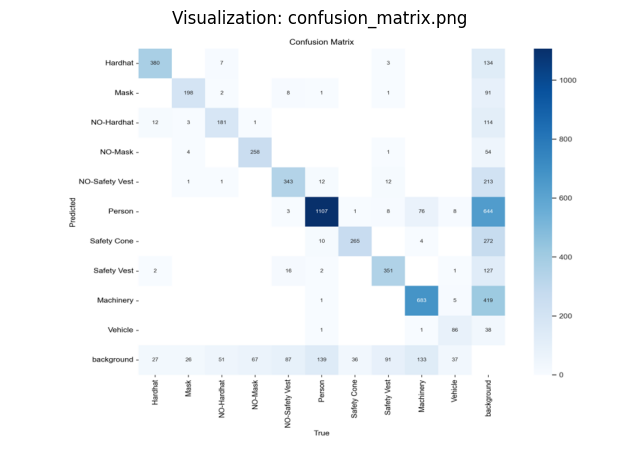

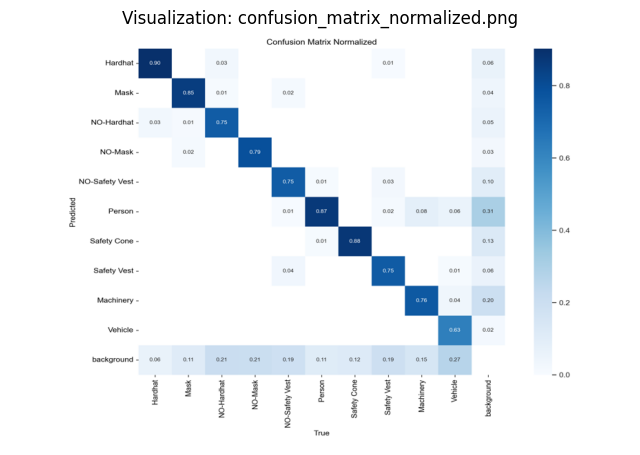

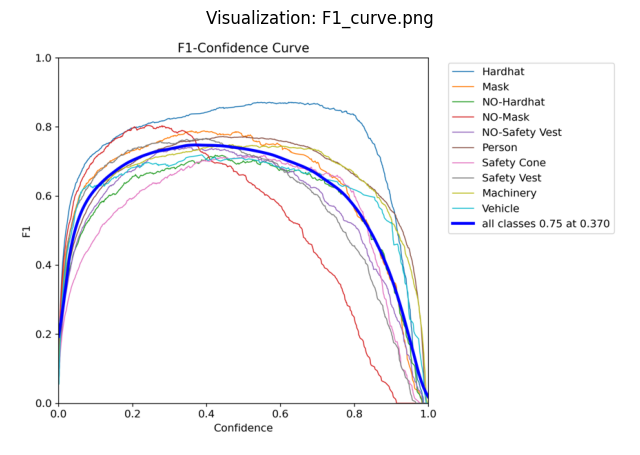

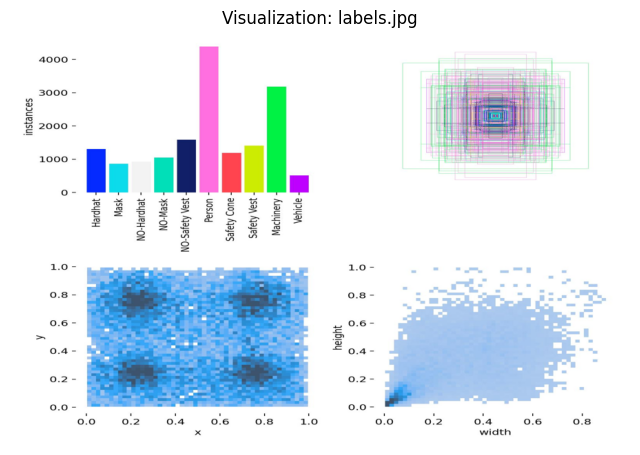

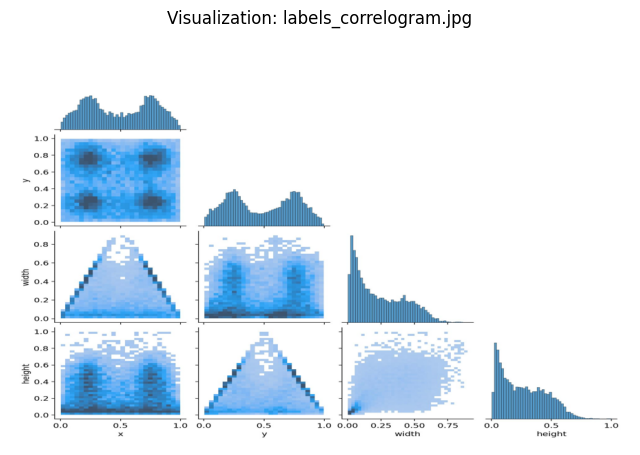

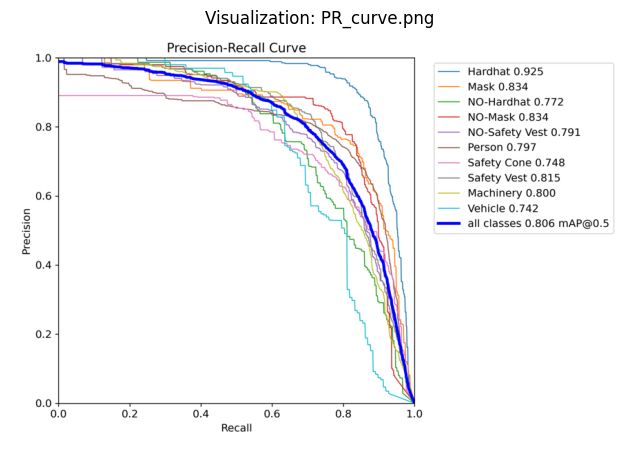

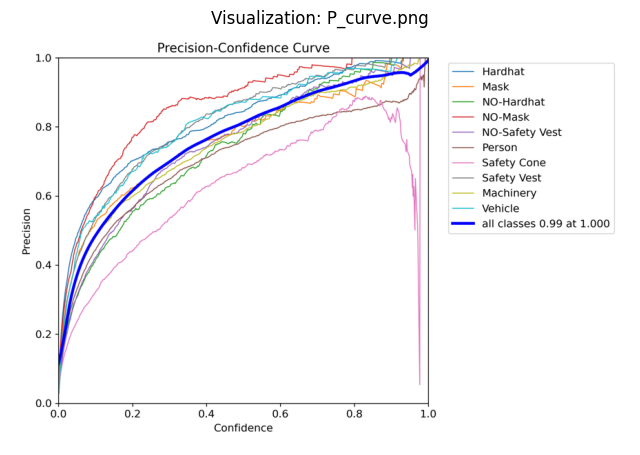

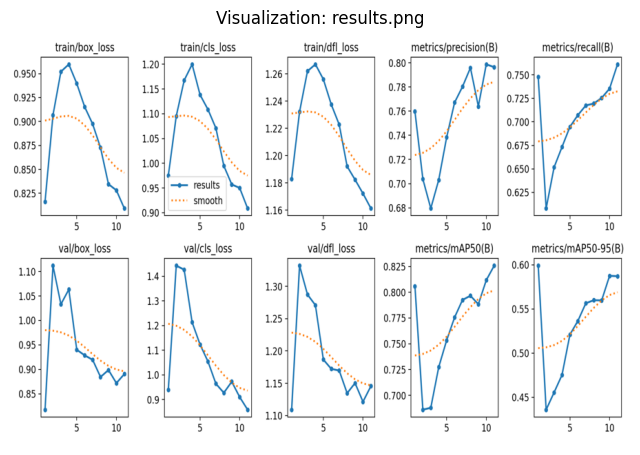

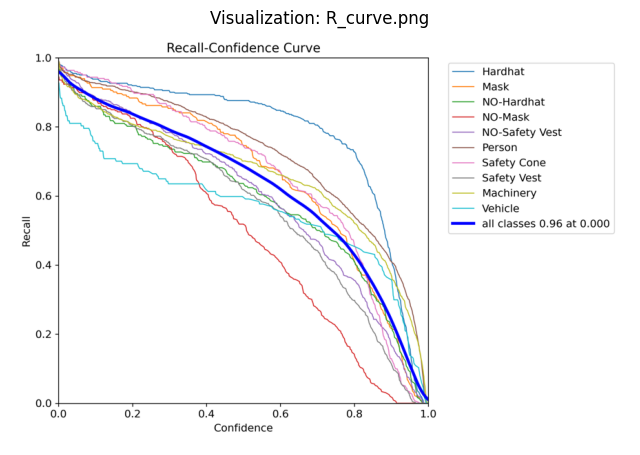

In [37]:
run_path = "runs/detect/" + input_name2
# loop through images, do not include images for val and train
img_files = [
    f for f in os.listdir(run_path) 
    if f.endswith((".png", ".jpg")) and not f.startswith(("train", "val"))
]

# Loop through each image file and display it
for img_file in img_files:
    file_path = os.path.join(run_path, img_file)
    image = Image.open(file_path).resize((900, 600)) # Width, height
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title(f"Visualization: {img_file}")
    plt.show()

### Visualize prediction on Kaggle dataset test set


image 1/1 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\images\test\777_jpg.rf.92dc6945342410ced7ac93f3dfbff0c5.jpg: 640x640 7 Safety Cones, 269.5ms
Speed: 2.0ms preprocess, 269.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


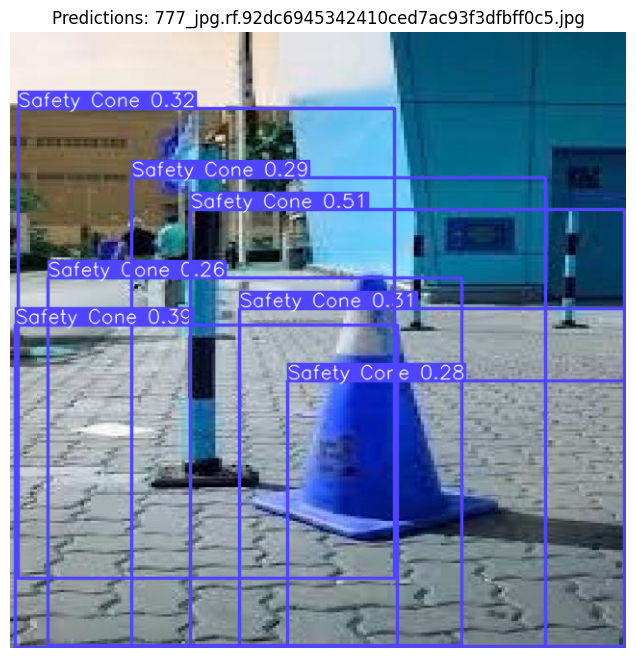


image 1/1 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\images\test\youtube-639_jpg.rf.351b2d526e4925e2d0bb07cca4f0609d.jpg: 640x640 1 NO-Hardhat, 4 Persons, 1 Safety Cone, 3 Machinerys, 142.2ms
Speed: 2.0ms preprocess, 142.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


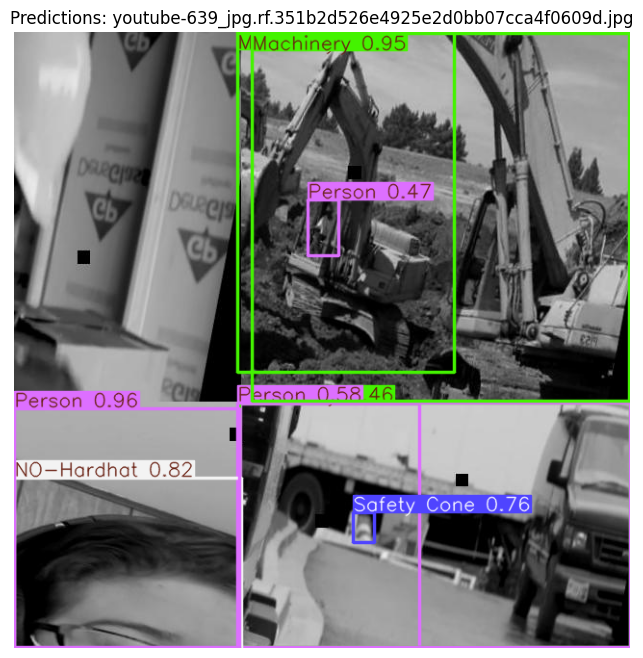


image 1/1 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\images\test\construction-572-_jpg.rf.e2b425bdd9d13b5d0f5c6362a81f21f4.jpg: 640x640 1 Hardhat, 1 Person, 5 Machinerys, 115.4ms
Speed: 5.9ms preprocess, 115.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


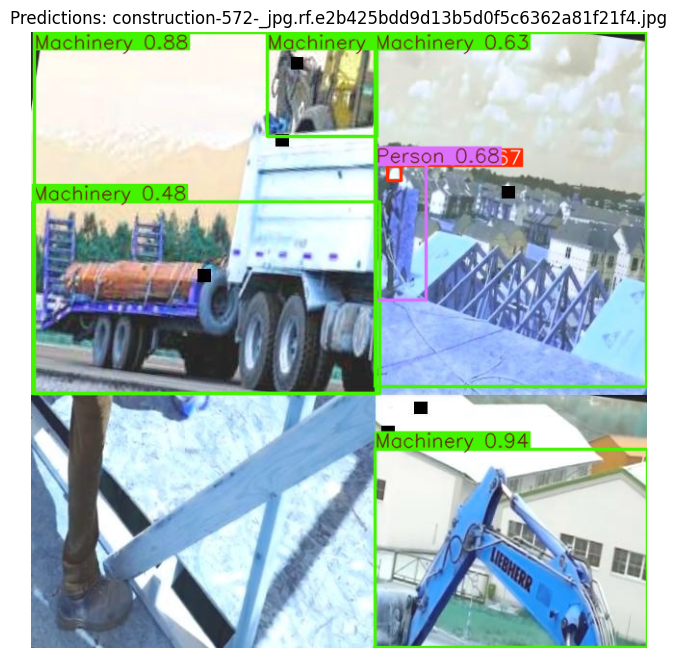

In [32]:
# load the final trained model
model = YOLO("runs/detect/" + input_name2 +"/weights/best.pt")

# Path to test images
test_images_dir = "datasets/images/test"

# get list of test images
test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# run inference and display predictions
# shuffle the images randomly
random.shuffle(test_images)

# limit to a subset 
test_images_subset = test_images[:3]

# Run inference and display predictions for random images
for test_image in test_images_subset:
    image_path = os.path.join(test_images_dir, test_image)
    results = model.predict(source=image_path, save=False)  # Run inference

    # Display the image with predictions
    img = results[0].plot()  # YOLOv8's built-in method to plot predictions
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predictions: {test_image}")
    plt.show()

# Make predictions on the <u>**unseen dataset**</u> test set

In [187]:
input_name2 = 'hybrid final 010125pm'
model = YOLO("runs/detect/" + input_name2 +"/weights/best.pt")

manual_test_images_dir = 'datasets/manually_annotated/TEST/images'
manual_test_labels_dir = 'datasets/manually_annotated/TEST/labels'

# Remove previous predictions
detect_path = "runs/detect/"
for folder in os.listdir(detect_path):
    folder_path = os.path.join(detect_path, folder)
    if os.path.isdir(folder_path) and folder.startswith("predict"):
        shutil.rmtree(folder_path, ignore_errors=True)

# Make predictions on all custom images
results = model.predict(
    f"{manual_test_images_dir}/scene*.jpg",
    save=True,
    conf=0.6,
    agnostic_nms=True,
    iou=0.8,
    verbose=False,
    seed = 88
)

Results saved to runs\detect\predict


# Bias Checks:

### Initial Qualitative Assessment
Manually inspect a sample of the model's predictions to visually evaluate its performance and look for patterns of bias in detections.
<br>
Load a subset of images and check if the model struggles with certain objects, environments, or conditions.

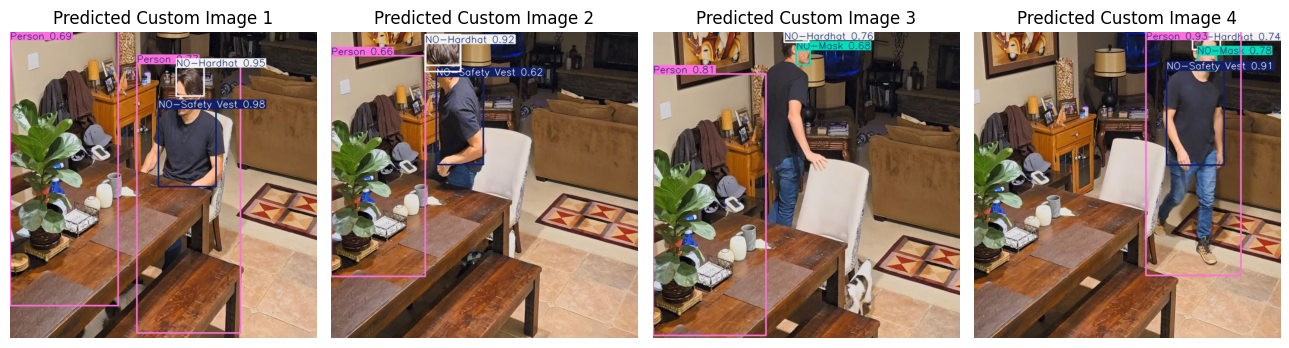

In [188]:
# Show predicted "scene" images
scene_predicted_paths = glob.glob("runs/detect/predict/scene*.jpg")[44:58] # Image range chosen for 4 images

if len(scene_predicted_paths) < 3:
    print("Not enough predictions found!")
else:
    fig, axes = plt.subplots(1, 4, figsize=(13, 6))  # 1 row, 3 columns
    for i, ax in enumerate(axes):
        image = mpimg.imread(scene_predicted_paths[i])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Predicted Custom Image {i + 1}")
    plt.tight_layout()
    plt.show()

## Interpretation:
On first glance, it seems to work aside from some confusion on Person and Machinery.
<br>May want to increase confidence threshold for all predictions.

### Save the predicted bbox coordinate data:

In [189]:
# Collect predictions into a DataFrame
predictions = []
for result in results:
    for box in result.boxes.data:  # YOLO v8 structure
        x1, y1, x2, y2, conf, cls = box.tolist()  # Coordinates, confidence, and class
        predictions.append({'image': result.path, 'class': int(cls), 'bbox': [x1, y1, x2, y2], 'conf': conf})

predictions_df = pd.DataFrame(predictions)
predictions_df['image'] = predictions_df['image'].apply(lambda x: os.path.basename(x)) # strip path from filename

### Load predefined ground truth bbox data

In [190]:
# Load ground truth annotations
ground_truths = []
for label_file in os.listdir(manual_test_labels_dir):
    if label_file.endswith(".txt"):
        image_name = label_file.replace(".txt", ".jpg")
        with open(os.path.join(manual_test_labels_dir, label_file), 'r') as f:
            for line in f:
                cls, x_center, y_center, width, height = map(float, line.strip().split())
                ground_truths.append({
                    'image': image_name,
                    'class': int(cls),
                    'bbox': [x_center, y_center, width, height]  # YOLO format
                })

ground_truths_df = pd.DataFrame(ground_truths)

In [191]:
predictions_df.head()

image  class                                               bbox  \
0  scene1_all_1.jpg      0  [469.28955078125, 26.16771125793457, 517.75634...   
1  scene1_all_1.jpg      5  [407.32000732421875, 20.86480712890625, 571.69...   
2  scene1_all_1.jpg      7  [426.65826416015625, 98.52215576171875, 541.91...   
3  scene1_all_1.jpg      8  [0.0, 401.7276611328125, 120.61820220947266, 5...   
4  scene1_all_2.jpg      0  [503.8622741699219, 21.861125946044922, 628.22...   

       conf  
0  0.960934  
1  0.959624  
2  0.869987  
3  0.752777  
4  0.916093

In [192]:
ground_truths_df.head()

image  class                                      bbox
0  scene1_all_1.jpg      1  [0.767531, 0.145336, 0.055563, 0.050984]
1  scene1_all_1.jpg      7   [0.757711, 0.275375, 0.151203, 0.25275]
2  scene1_all_1.jpg      5  [0.755242, 0.379492, 0.203703, 0.677891]
3  scene1_all_1.jpg      0  [0.771016, 0.075391, 0.078906, 0.066406]
4  scene1_all_2.jpg      5  [0.771844, 0.522648, 0.456313, 0.954703]

### Convert coordinates from normalized to absolute format

In [193]:
#Convert normalized to absolute format
image_width = 640
image_height = 640
def yolo_to_absolute(bbox, image_width, image_height):
    x_center, y_center, width, height = bbox
    x1 = (x_center - width / 2) * image_width
    y1 = (y_center - height / 2) * image_height
    x2 = (x_center + width / 2) * image_width
    y2 = (y_center + height / 2) * image_height
    return [x1, y1, x2, y2]
# apply to ground truth values
ground_truths_df['bbox'] = ground_truths_df['bbox'].apply(
    lambda bbox: yolo_to_absolute(bbox, image_width, image_height)
)

In [194]:
ground_truths_df.head()

image  class                                               bbox
0  scene1_all_1.jpg      1  [473.43967999999995, 76.70016, 509.0, 109.3299...
1  scene1_all_1.jpg      7  [436.55008000000004, 95.36, 533.32, 257.119999...
2  scene1_all_1.jpg      5  [418.16992, 25.94975999999999, 548.53983999999...
3  scene1_all_1.jpg      0  [468.20032000000003, 27.00032, 518.70016, 69.5...
4  scene1_all_2.jpg      5  [347.96, 28.98976000000001, 640.0003200000001,...

### Calculate IoU

In [195]:
from shapely.geometry import box

def calculate_iou(box1, box2):
    # Convert [x1, y1, x2, y2] into shapely boxes
    box1 = box(*box1)
    box2 = box(*box2)
    intersection = box1.intersection(box2).area
    union = box1.union(box2).area
    return intersection / union

# Match predictions to ground truth and calculate IoU
ious = []
for _, pred in predictions_df.iterrows():
    gt_matches = ground_truths_df[ground_truths_df['image'] == pred['image']]
    for _, gt in gt_matches.iterrows():
        if pred['class'] == gt['class']:  # Match classes
            pred_bbox = pred['bbox']  # [x1, y1, x2, y2]
            gt_bbox = gt['bbox']  # Convert YOLO bbox to absolute format
            iou = calculate_iou(pred_bbox, gt_bbox)
            ious.append({'object_class': pred['class'], 'iou': iou})

iou_df = pd.DataFrame(ious)

# Average IoU per class item

In [196]:
# Group by object class and compute average IoU across all predictions for that class
# (1.0 iou equals perfect alignment with ground truth)
mean_iou = iou_df.groupby('object_class')['iou'].mean()
mean_iou_rounded = mean_iou.round(2)
print(mean_iou_rounded)

object_class
0    0.84
2    0.75
3    0.57
4    0.73
5    0.57
7    0.79
Name: iou, dtype: float64


# ****Class 1 (Mask) is missing

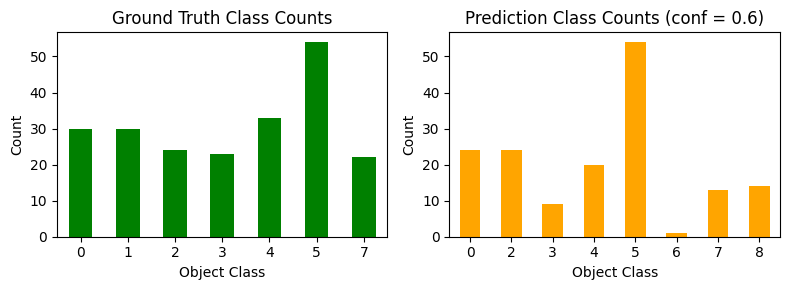

In [206]:
import matplotlib.pyplot as plt

# Count occurrences of each class in ground truth
class_counts = ground_truths_df['class'].value_counts()

# Sort class counts by object class in alphanumerical order
sorted_class_counts = class_counts.sort_index()

# Count occurrences of each class in predictions
pred_class_counts = predictions_df['class'].value_counts()
sort_pred_class_counts = pred_class_counts.sort_index()

# Create a figure with 1 row and 2 columns for subplots
plt.figure(figsize=(8, 3))

# Plot ground truth class counts in the first subplot
plt.subplot(1, 2, 1)  # (rows, columns, index)
sorted_class_counts.plot(kind='bar', color='green')
plt.title('Ground Truth Class Counts')
plt.xlabel('Object Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Plot prediction class counts in the second subplot
plt.subplot(1, 2, 2)  # (rows, columns, index)
sort_pred_class_counts.plot(kind='bar', color='orange')
plt.title('Prediction Class Counts (conf = 0.6)')
plt.xlabel('Object Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show both plots
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

### ***No predictions for class 1 (Mask) found

A significant imbalance in the predicted class distribution may suggest bias, especially if you know the real-world distribution should be different.

### Confidence Score Analysis
Analyze the confidence scores, identify patterns of overconfidence or underconfidence.
<br>Consistently lower confidence scores for certain classes could indicate a bias in the model's predictions.

In [122]:
from collections import defaultdict

# Extract the relevant columns from the predictions dataframe
predictions = predictions_df[['class', 'conf']].to_dict(orient='records')

# Aggregate confidence by class
confidence_by_class = defaultdict(list)
for pred in predictions:
    confidence_by_class[pred['class']].append(pred['conf'])

# Calculate average confidence per class
avg_confidence = {cls: sum(scores) / len(scores) for cls, scores in confidence_by_class.items()}

# Round the average confidence values to 2 decimal places
avg_conf_round = {cls: round(conf, 2) for cls, conf in avg_confidence.items()}

# Print the average confidence for each class
print(f"Average Confidence Score for Each Class:\n {avg_conf_round}")

Average Confidence Score for Each Class:
 {0: 0.67, 5: 0.5, 7: 0.56, 8: 0.41, 4: 0.55, 3: 0.55, 2: 0.64, 6: 0.38, 9: 0.24}


# WIP:

### False Positive and False Negative Rates
Identify which classes have the highest false positives (objects incorrectly detected) and false negatives (objects missed).

In [200]:
from sklearn.metrics import confusion_matrix

# Filter the dataframes to include only matching images
matching_images = ground_truths_df['image'].isin(predictions_df['image'])
ground_truths_df = ground_truths_df[matching_images]
predictions_df = predictions_df[matching_images]

# Check lengths again after filtering
print(f"Number of ground truth samples: {len(ground_truths_df)}")
print(f"Number of prediction samples: {len(predictions_df)}")

# Extract ground-truth and predicted classes from your dataframes
y_true = ground_truths_df['class'].values  # Ground truth labels
y_pred = predictions_df['class'].values    # Predicted labels

# Generate confusion matrix
labels = ground_truths_df['class'].unique()  # Use unique classes from the ground truth
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:\n", cm)

Number of ground truth samples: 216
Number of prediction samples: 159


ValueError: Found input variables with inconsistent numbers of samples: [216, 159]

### Class-Wise Performance Analysis
Significant differences in metrics between classes may indicate bias toward or against certain object categories.

In [199]:
from sklearn.metrics import classification_report

# Extract ground-truth and predicted class labels from the dataframes
y_true = ground_truths_df['class'].values
y_pred = predictions_df['class'].values

# Generate class-wise performance metrics
report = classification_report(y_true, y_pred, output_dict=True)
print(report)

ValueError: Found input variables with inconsistent numbers of samples: [224, 159]